# Training and evaluation of modified IM2ELEVATION model

In [12]:
# Ensures runtime code is updated when source code of libraries are updated as well
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Import of necessary libraries

import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import numpy as np
import pickle
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import ssl
import tqdm

from osgeo import gdal
import geopandas as gpd
import shapely
from scipy.ndimage import rotate

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.preprocessing import Normalizer

# FastAI
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

import utils.data_utils as du
import utils.sp_utils as sp



In [14]:
# User modules

from utils.models import senet
from utils.models import modules
from utils.models import net

In [15]:
# Check if gpu/cuda is available
import torch
torch.cuda.is_available()

True

In [16]:
# Constants
CHECKPT_PATH = "pretrained_model/im2elevation/Block0_skip_model_110.pth.tar"
UMP = ["AverageHeightArea", 
            "AverageHeightBuilding", 
            "AverageHeightTotalArea", 
            # "Displacement", 
            "FrontalAreaIndex",
            "MaximumHeight",
            "PercentileHeight",
            "PlanarAreaIndex",
            # "RoughnessLength",
            "StandardDeviation"]


## Build Dataset

In [26]:
Y_tokyo = gpd.read_feather("data/Y_UMP/Y_tokyo_7.feather")
ds_tokyo = du.UMPDataset(Y_tokyo, "data/X_sentinel/tokyo")

In [27]:
Y_osaka = gpd.read_feather("data/Y_UMP/Y_osaka_7.feather")
ds_osaka = du.UMPDataset(Y_osaka, "data/X_sentinel/osaka")

In [28]:
with open("data/ds_tokyo.pkl", "wb") as f:
    pickle.dump(ds_tokyo, f)

with open("data/ds_osaka.pkl", "wb") as f:
    pickle.dump(ds_osaka, f)

### Load previously generated dataset

In [6]:
with open("data/ds_tokyo.pkl", "rb") as f:
    ds_tokyo = pickle.load(f)

with open("data/ds_osaka.pkl", "rb") as f:
    ds_osaka = pickle.load(f)

#### Old Dataset

In [19]:
with open("data/x_train_tokyo.pkl", "rb") as f:
    old_x_train = pickle.load(f)

with open("data/x_val_tokyo.pkl", "rb") as f:
    old_x_val = pickle.load(f)

with open("data/y_train_tokyo.pkl", "rb") as f:
    old_y_train = pickle.load(f)

with open("data/y_val_tokyo.pkl", "rb") as f:
    old_y_val = pickle.load(f)

# Reorder old_y_
# old_y_train = old_y_train[:, [1, 0, 2, 7, 4, 5, 6, 3]]
# old_y_val = old_y_val[:, [1, 0, 2, 7, 4, 5, 6, 3]]
## Old
old_dls = DataLoaders().from_dsets(list(zip(old_x_train, old_y_train)), list(zip(old_x_val, old_y_val)), bs= 64, device=torch.device('cuda'))
# old_dls = DataLoaders().from_dsets(list(zip(old_x_train, old_y_train)), list(zip(old_x_val, old_y_val)), bs= 8, device=torch.device('cuda'))

In [20]:
# Adapting the old dataset to the new dataset format
# Generate the max and min for each channel and each UMP

old_ds_channel_max = [0 for _ in range(12)]
old_ds_UMP_max = [0 for _ in range(8)]
# Using the roundabout way because there seems to be a bug with iterating directly
for entry in range(len(old_x_train)):
    image = old_x_train[entry]
    UMPs = old_y_train[entry]
    for channel in range(len(image)):
        # The image
        cur_max = image[channel].max()
        if cur_max > old_ds_channel_max[channel]:
            old_ds_channel_max[channel] = cur_max
    
    for ump in range(len(UMPs)):
        cur_max = UMPs[ump]
        if cur_max > old_ds_UMP_max[ump]:
            old_ds_UMP_max[ump] = cur_max

old_ds_channel_max, old_ds_UMP_max

([5232.0,
  12216.0,
  14792.0,
  16032.0,
  15665.0,
  15742.0,
  15663.0,
  15607.0,
  15569.0,
  7385.0,
  14959.0,
  15063.0],
 [74.241776,
  125.18466,
  39.780518,
  898388.9,
  332.9,
  202.592,
  0.49090356,
  1.0470364])

In [11]:
# Adapting the old dataset to the new dataset format
# Generate the max and min for each channel and each UMP

old_x_train[:, 0, :].max()

5232.0

### Visualisation Functions

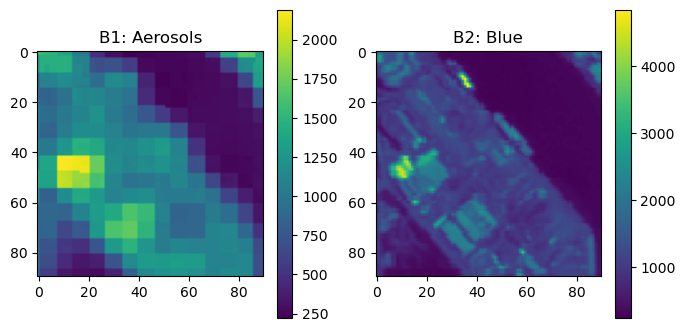

In [32]:
du.plotArray(rotate(ds_osaka[0][0][:2], 90, axes= (2, 1)))

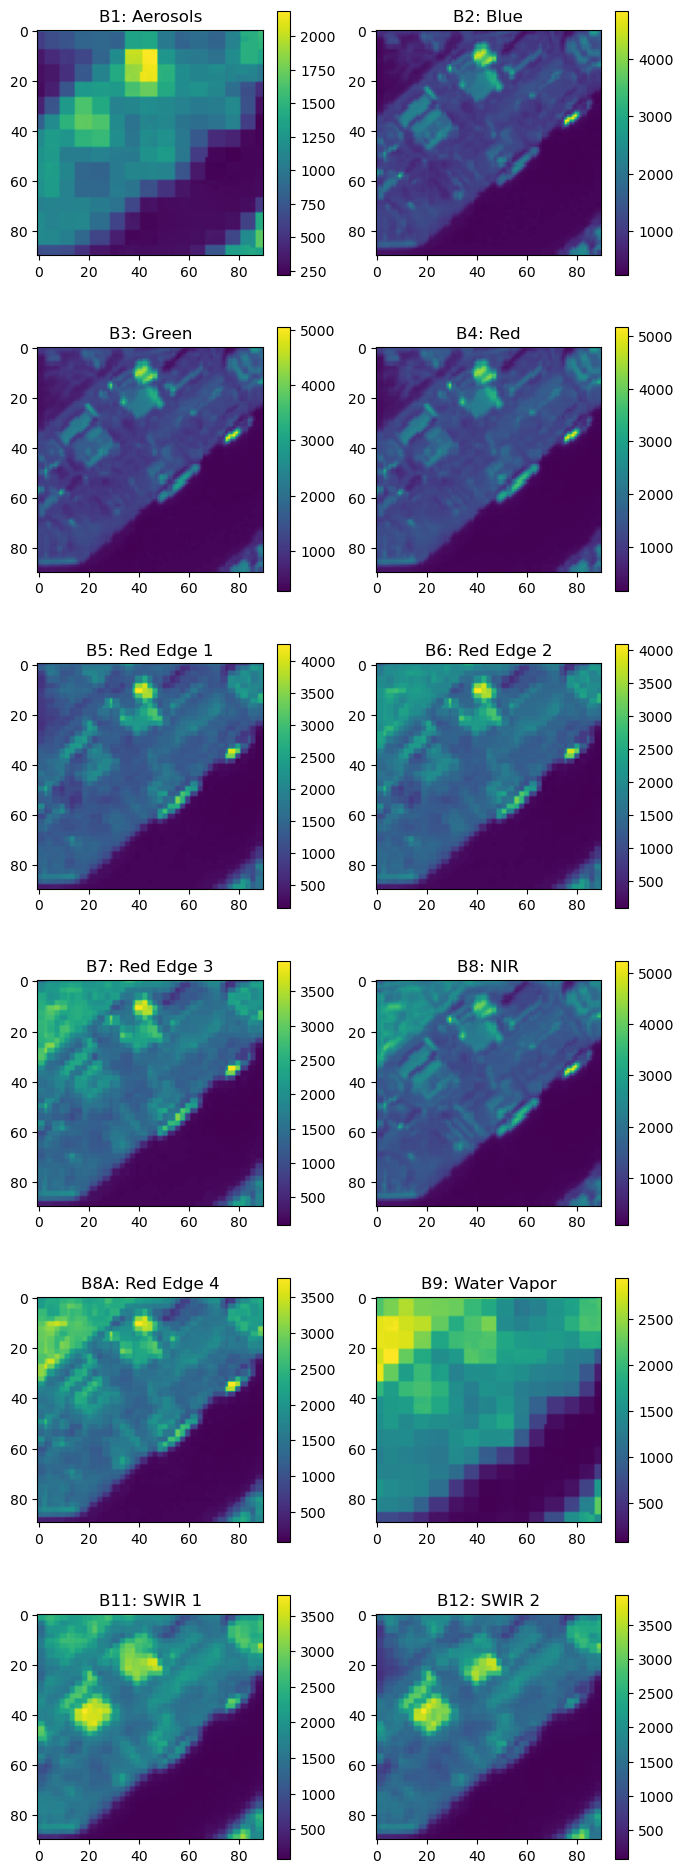

In [10]:
du.plotArray(ds_osaka[0][0])

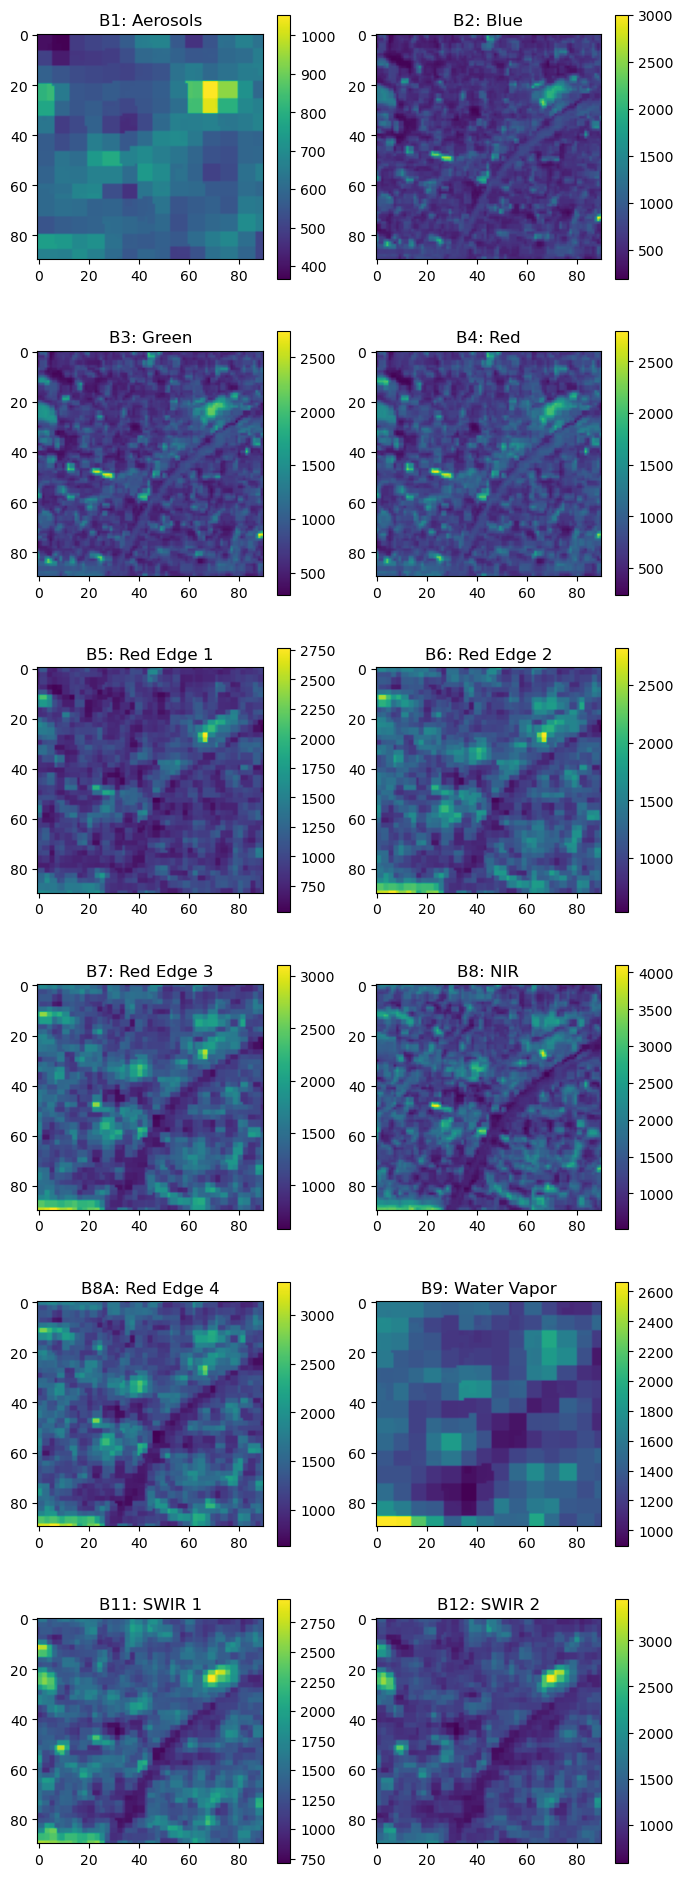

In [11]:
du.plotArray(ds_tokyo[0][0])

### Check dataset

In [80]:
len(ds_osaka), len(ds_tokyo)

(1145, 3286)

In [81]:
# Check for shape discrepancies
for i in range(len(ds_osaka)):
    ds_osaka[i]

In [82]:
# Check for shape discrepancies
for i in range(len(ds_tokyo)):
    ds_tokyo[i]

In [9]:
ds_tokyo.channel_max

[5232.0,
 12216.0,
 14792.0,
 16032.0,
 15665.0,
 15742.0,
 15663.0,
 15607.0,
 15569.0,
 7385.0,
 14959.0,
 15063.0]

### Create FastAI dataloaders

In [7]:
dl = DataLoaders().from_dsets(ds_tokyo, ds_osaka, bs= 64, device=torch.device('cuda'))
# dl = DataLoaders().from_dsets(ds_tokyo, ds_osaka, bs= 8, device=torch.device('cuda'))

#### Validate the shape and len

In [34]:
# Check that dimensions are right
test_batch = dl.one_batch()

In [35]:
# Validate shape
test_batch[0].shape, test_batch[1].shape

(torch.Size([64, 12, 90, 90]), torch.Size([64, 8]))

In [36]:
# Validate len
len(dl.train_ds), len(dl.valid_ds)

(13144, 4580)

## Training the Model

### Model using custom weights (12 channels)
- Using weights from IM2ELEVATION
- Expand model to accept 12 channels instead of just 3

### Load all weights

In [8]:
# Load weights from IM2ELEVATION and delete unnecessary layers
checkpoint = torch.load(CHECKPT_PATH) # The original IM2ELEVATION weights
# checkpoint = torch.load("trained_models/model_customhead_w_64_40.pth")

to_delete = []
# for layer in checkpoint.keys():
for layer in checkpoint["state_dict"].keys():
    if any([word in layer.upper() for word in ["HARM", "R.CONV4", "R.BN4", "R2"]]):
    # if any([word in layer.upper() for word in ["HARM", "R.CONV3", "R.BN3", "R.CONV4", "R.BN4"]]):
        to_delete.append(layer)
print(to_delete)

for i in to_delete:
    # checkpoint.pop(i)
    checkpoint["state_dict"].pop(i)

# Load Weights
ssl._create_default_https_context = ssl._create_unverified_context

original_model = senet.senet154()

Encoder = modules.E_senet(original_model, dl.train_ds.channel_max) # For new ds
# Encoder = modules.E_senet(original_model, old_ds_channel_max) # For old ds
# model = net.model(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])

# model = net.model_n12(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])
model = net.model_n12_light(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])




['E.Harm.dct', 'E.Harm.weight', 'E.Harm.bias', 'R.conv4.weight', 'R.conv4.bias']


In [11]:
# Duplicate the weights for the encoders
for k in list(checkpoint["state_dict"].keys()):
    if "E." in k:
        for i in range(4):
            checkpoint["state_dict"][f"E{i}." + k[2:]] = checkpoint["state_dict"][k]

In [9]:
# Load weights
model.load_state_dict(checkpoint["state_dict"], strict=False)

# Clear memory
del checkpoint
gc.collect()
torch.cuda.empty_cache()

### Load weights (Encoder only)

In [10]:
# Load weights from IM2ELEVATION and delete unnecessary layers
checkpoint = torch.load(CHECKPT_PATH)

to_delete = []
for layer in checkpoint["state_dict"].keys():
    if any([word in layer.upper() for word in ["HARM", "R.CONV4", "R.BN4"]]):
    # if any([word in layer.upper() for word in ["HARM", "R.CONV3", "R.BN3", "R.CONV4", "R.BN4"]]):
        to_delete.append(layer)
print(to_delete)

for i in to_delete:
    checkpoint["state_dict"].pop(i)

# Load Weights
ssl._create_default_https_context = ssl._create_unverified_context

original_model = senet.senet154()

# Encoder = modules.E_senet(original_model, x_norms)
Encoder = modules.E_senet(original_model, dl.train_ds.channel_max)
# Encoder = modules.E_senet(original_model, old_ds_channel_max)
model = net.model(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])

# Load trimmed im2elevation weights
model.load_state_dict(checkpoint["state_dict"], strict=False)

# Clear memory
del checkpoint
gc.collect()
torch.cuda.empty_cache()

model = net.model_n12(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])

['E.Harm.dct', 'E.Harm.weight', 'E.Harm.bias', 'R.conv4.weight', 'R.conv4.bias']


### Check Model Sanity

In [30]:
test_batch = old_dls.one_batch()[0]
# test_batch = dl.one_batch()[0]
test_batch.dtype

torch.float32

In [31]:
model.eval()
model.cuda()
model(test_batch).shape

torch.Size([8, 8])

### Loss and Metrics

In [19]:
dl.train_ds[0][1]

array([ 8.229219  ,  7.3927827 ,  1.9925671 ,  0.1882118 , 28.4       ,
       11.9       ,  0.24213319,  3.2839909 ], dtype=float32)

In [14]:
dl.train_ds.UMP_max

[179.837, 69.9, 19.801067, 1.0278143, 262.0, 217.22, 0.4841617, 45.97128]

In [15]:
ump_max = [0 for _ in range(8)]
for i in range(len(dl.train_ds)):
    for j in range(8):
        if dl.train_ds[i][1][j] > ump_max[j]:
            ump_max[j] = dl.train_ds[i][1][j]

ump_max

[179.837, 69.9, 19.801067, 1.0278143, 262.0, 217.22, 0.4841617, 45.97128]

In [16]:
np.array(dl.train_ds, dtype= object)[:, 1].shape

(3286,)

In [10]:
# Loss Function

# def mse_weighted(pred, actual, UMP_max= old_ds_UMP_max):
def mse_weighted(pred, actual, UMP_max= dl.train_ds.UMP_max):
    """
    Weighted loss function that normalises the predictions based on the parameters used to normalise the actual during training
    """
    loss = tensor(0).float()
    loss.requires_grad_(True)
    for ump in range(pred.shape[1]):
        # loss = torch.add(loss, F.mse_loss(pred[:, ump], actual[:, ump]))
        loss = torch.add(loss, torch.div(F.mse_loss(pred[:, ump], actual[:, ump]), UMP_max[ump]**2))
    if loss.isnan().sum() > 1:
        raise ValueError([pred, actual])
    return loss.float()


In [11]:
# List of metrics
"""
"AverageHeightArea", 
"AverageHeightBuilding", 
"AverageHeightTotalArea", 
"Displacement", 
"FrontalAreaIndex",
"MaximumHeight",
"PercentileHeight",
"PlanarAreaIndex",
"RoughnessLength",
"StandardDeviation"
"""
def AverageHeightArea_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 0], actual[:, 0]))

def AverageHeightBuilding_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 1], actual[:, 1]))

def AverageHeightTotalArea_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 2], actual[:, 2]))

# def Displacement_RMSE(pred, actual):
#     return math.sqrt(F.mse_loss(pred[:, 3], actual[:, 3]))

def FrontalAreaIndex_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 3], actual[:, 3]))
    # return math.sqrt(F.mse_loss(pred[:, 4], actual[:, 4]))

def MaximumHeight_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 4], actual[:, 4]))
    # return math.sqrt(F.mse_loss(pred[:, 5], actual[:, 5]))

def PercentileHeight_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 5], actual[:, 5]))
    # return math.sqrt(F.mse_loss(pred[:, 6], actual[:, 6]))

def PlanarAreaIndex_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 6], actual[:, 6]))
    # return math.sqrt(F.mse_loss(pred[:, 7], actual[:, 7]))

# def RoughnessLength_RMSE(pred, actual):
#     return math.sqrt(F.mse_loss(pred[:, 8], actual[:, 8]))

def StandardDeviation_RMSE(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 7], actual[:, 7]))
    # return math.sqrt(F.mse_loss(pred[:, 9], actual[:, 9]))

metrics = [
    AverageHeightArea_RMSE, 
    AverageHeightBuilding_RMSE,
    AverageHeightTotalArea_RMSE,
    # Displacement_RMSE,
    FrontalAreaIndex_RMSE,
    MaximumHeight_RMSE,
    PercentileHeight_RMSE,
    PlanarAreaIndex_RMSE,
    # RoughnessLength_RMSE,
    StandardDeviation_RMSE
]

### Train Model

In [12]:
# Need better loss due to scale difference
model.train()
# learn = Learner(old_dls, model, loss_func= mse_weighted, metrics= metrics, cbs=[MixedPrecision, FP16TestCallback])
learn = Learner(dl, model, loss_func= mse_weighted, metrics= metrics, cbs=[MixedPrecision, FP16TestCallback])

In [13]:
learn.lr_find()

RuntimeError: Unable to find a valid cuDNN algorithm to run convolution

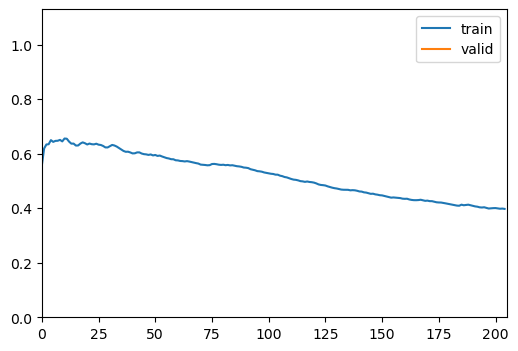

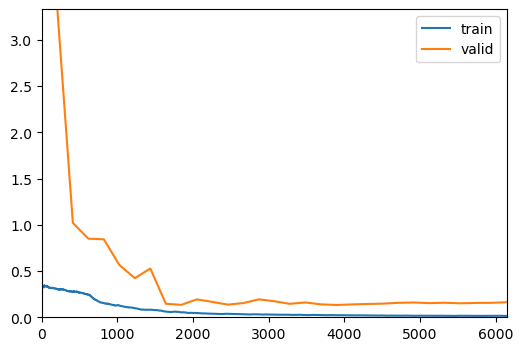

In [43]:
# LR is 0.06. 0.12 loss
learn.fine_tune(30, 0.001, freeze_epochs= 1, cbs= [ShowGraphCallback()])

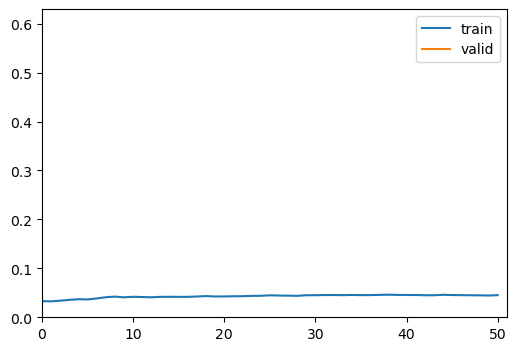

In [20]:
model.train()
learn.fit_one_cycle(1, 0.001, cbs= [ShowGraphCallback()])

In [21]:
# Plateaus around 30
name = "light_ump_cut_12ch_64_10" # <description>_<batch_size>_<epochs>
torch.save(model.state_dict(), f"trained_models/model_weight_{name}.pth")
# torch.save(model, f"trained_models/model_{name}.pth")

with open(f"trained_models/model_records_{name}.pkl", "wb") as f:
    pickle.dump(learn.recorder.values, f)

In [40]:
# Save using learner
learn.save(f"model_weight_learner_{name}")

Path('models/model_weight_learner_v5_oldds_ump_cut_12ch_8_3.pth.pth')

## Visualising Model Performance (New ver.)

### Load Data

In [10]:
# Dataloader for evaluation only (large batch size)
dl_eval = DataLoaders().from_dsets(ds_tokyo, ds_osaka, bs= 106, device=torch.device('cuda'))
# for i in dl_eval[0]:
#     test_batch = i
#     break
# with open("test_batch.pkl", "wb") as f:     
#     pickle.dump(test_batch, f)

In [10]:
# New train data batch
with open("test_batch.pkl", "rb") as f:     
    test_batch = pickle.load(f)

In [11]:
# Old train/val
# Import train and validation
with open("data/x_train_tokyo.pkl", "rb") as f:
    x_train = pickle.load(f)

with open("data/x_val_tokyo.pkl", "rb") as f:
    x_val = pickle.load(f)

with open("data/y_train_tokyo.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("data/y_val_tokyo.pkl", "rb") as f:
    y_val = pickle.load(f)

In [12]:
# Util classes
class NDNormalizer:
    """
    Class that normalises the values from 0 - 255 to match the inputs that the original senet is trained on
    """
    def __init__(self, x):
        self.min_x = x.min()
        self.max_x = x.max()
    
    def transform(self, new_x):
        return (new_x / self.max_x) * 255

    def revert(self, new_x):
        return new_x * self.max_x / 255

In [13]:
x_norms = []
x_train_norm = np.array(x_train)
for channel in range(x_train.shape[1]):
    x_norms.append(NDNormalizer(x_train[:, channel]))
    # x_norms.append(MinMaxScaler().fit(x_train[:, channel]))
    x_train_norm[:, channel] = x_norms[channel].transform(x_train[:, channel])

y_norms = []
y_train_norm = np.array(y_train)
for ump in range(y_train.shape[1]):
    y_norms.append(NDNormalizer(y_train[:, ump]))
    y_train_norm[:, ump] = y_norms[ump].transform(y_train[:, ump])

### Initialise model with weights

In [21]:
# Load weights from previously trained model
# checkpoint = torch.load("trained_models/model_weight_new_1_12ch_8_15.pth", map_location="cuda:0")
# checkpoint = torch.load("trained_models/model_weight_v2_12ch_8_6.pth", map_location="cuda:0")
# checkpoint = torch.load("trained_models/model_weight_old_12ch_8_15.pth", map_location="cuda:0")
# checkpoint = torch.load("trained_models/model_customhead_w_64_40.pth", map_location="cuda:0")
# checkpoint = torch.load("trained_models/model_weight_v4_ump_cut_12ch_8_15.pth", map_location="cuda:0")
# checkpoint = torch.load("trained_models/model_weight_12ch_8_15.pth", map_location="cuda:0")
# checkpoint = torch.load("trained_models/model_weight_v5_ump_cut_12ch_8_5.pth", map_location="cuda:0")
# checkpoint = torch.load("trained_models/model_weight_v5_oldds_ump_cut_12ch_8_3.pth", map_location="cuda:0")
# checkpoint = torch.load("trained_models/model_weight_v5_oldds_ump_cut_12ch_8_30.pth", map_location="cuda:0")
checkpoint = torch.load("trained_models/model_weight_old_good_12ch_8_8.pth", map_location="cuda:0")

# to_delete = []
# # for layer in checkpoint.keys():
# for layer in checkpoint.keys():
#     if any([word in layer.upper() for word in ["R2"]]):
#     # if any([word in layer.upper() for word in ["HARM", "R.CONV3", "R.BN3", "R.CONV4", "R.BN4"]]):
#         to_delete.append(layer)
# print(to_delete)

# for i in to_delete:
#     # checkpoint.pop(i)
#     checkpoint.pop(i)


# Rebuild the model
ssl._create_default_https_context = ssl._create_unverified_context
original_model = senet.senet154()
# For the old dataset
Encoder = modules.E_senet(original_model, old_ds_channel_max)
# Encoder = modules.E_senet(original_model, dl.train_ds.channel_max)
model = net.model_n12_light(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])
# model = net.model_n12(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])
# model = net.model_n12_visualise(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])


# Load in the weights
device = torch.device("cuda")
model.load_state_dict(checkpoint, strict=True)
model.to(device)
model.eval();

In [22]:
# Clear memory
del checkpoint
gc.collect()
torch.cuda.empty_cache()

### Initialise model directly (old models)

In [11]:
# Load CNN Model Directly
# model = torch.load("trained_models/model_customhead.pth")
# model = torch.load("trained_models/model_customhead_64_40.pth")
# model = torch.load("trained_models/model_12ch_8_15.pth")
model = torch.load("trained_models/model_v5_ump_cut_12ch_8_5.pth")
model.eval()
model.cuda()

model.E0.channel_max = dl_eval.train_ds.channel_max
model.E1.channel_max = dl_eval.train_ds.channel_max
model.E2.channel_max = dl_eval.train_ds.channel_max
model.E3.channel_max = dl_eval.train_ds.channel_max

# model.E0.channel_max = [x_norms[i].max_x for i in range(0, 12)]
# model.E1.channel_max = [x_norms[i].max_x for i in range(0, 12)]
# model.E2.channel_max = [x_norms[i].max_x for i in range(0, 12)]
# model.E3.channel_max = [x_norms[i].max_x for i in range(0, 12)]

In [ ]:
# CNN Predictions for x_train
with torch.no_grad():
    preds_trains = tensor([])
    for i in range(0, len(x_train), 64):
        # x_train_cur = tensor(x_train[i, 1:4]).detach().clone().unsqueeze(0)
        x_train_cur = tensor(x_train[i:min(i+64, len(x_train))])
        preds_train = tensor(model(x_train_cur.cuda())).cpu()
        preds_trains = torch.cat([preds_trains, preds_train], 0)
    # preds_val = preds_val.cat([preds_val, tensor(model(tensor(x_val[len(x_val)//2:, 1:4])))], dim= 0)
    print(preds_trains.shape)

torch.Size([2628, 8])


In [ ]:
# CNN Predictions for x_val
with torch.no_grad():
    preds_vals = tensor([])
    for i in range(0, len(x_val), 64):
        x_val_cur = tensor(x_val[i:min(i+64, len(x_val))])
        # x_val_cur = tensor(x_val[i, 1:4]).detach().clone().unsqueeze(0)
        preds_val = tensor(model(x_val_cur.cuda())).cpu()
        preds_vals = torch.cat([preds_vals, preds_val], 0)
    # preds_val = preds_val.cat([preds_val, tensor(model(tensor(x_val[len(x_val)//2:, 1:4])))], dim= 0)
    print(preds_vals.shape)

torch.Size([614, 8])


### Get predictions (new)

In [12]:
factors = []
factors_1 = []
for i in range(1, len(dl.train_ds) // 2):
    if len(dl.train_ds) % i == 0:
        factors.append(i)
    elif len(dl.train_ds) % i == 1:
        factors_1.append(i)

print("Perfect Batch Sizes:", factors)
print("Missing 1 Batch Sizes", factors_1)

Perfect Batch Sizes: [1, 2, 31, 53, 62, 106]
Missing 1 Batch Sizes [3, 5, 9, 15, 45, 73, 219, 365, 657, 1095]


In [23]:
model.eval()
# dl_eval = dl
# Train set
device = torch.device("cuda")
preds = []
Y_train = []
with torch.no_grad():
    for batch in tqdm.tqdm(old_dls[0]):
    # for batch in tqdm.tqdm(dl_eval[0]):
        preds.append(model(batch[0]).cpu())
        Y_train.append(batch[1].cpu())
       
preds = torch.cat(preds)
Y_train = torch.cat(Y_train)

100%|██████████| 41/41 [00:15<00:00,  2.59it/s]


In [32]:
# Validation set
preds, Y_train = learn.get_preds(ds_idx= 0)

In [26]:
learn.validate(ds_idx= 0)

(#9) [0.582221508026123,24.028809039576892,13.316269571640222,7.203318188619641,0.25381463041235597,97.23786616545765,41.703798284128425,0.25275710841844007,56828.94665761286]

In [29]:
learn.validate(ds_idx= 0)

(#9) [0.2174762338399887,18.176914120925623,8.47360425653401,4.053279595122516,0.12116095068706521,85.89509873877594,34.717134833427195,0.09473721806312092,57783.10433245148]

#### Get predictions (old)

In [19]:
model.eval()
device = torch.device("cuda")
with torch.no_grad():
    preds = []
    for batch_idx in tqdm.tqdm(range(0, len(x_train), 106)):
        batch = torch.tensor(x_train[batch_idx:batch_idx + 106])
        preds.append(model(batch.to(device)))

preds = torch.cat(preds)
preds.shape

100%|██████████| 25/25 [00:20<00:00,  1.19it/s]


torch.Size([2628, 8])

In [20]:
Y_train.shape

(2628, 8)

### Plotting results

In [44]:
x_train = np.array([i[0] for i in tqdm.tqdm(dl.train_ds)])
x_val = np.array([i[0] for i in tqdm.tqdm(dl.valid_ds)])
Y_train = np.array([i[1] for i in tqdm.tqdm(dl.train_ds)])
Y_val = np.array([i[1] for i in tqdm.tqdm(dl.valid_ds)])

x_train.shape, x_val.shape, Y_train.shape, Y_val.shape

((13144, 12, 90, 90), (4580, 12, 90, 90), (13144, 8), (4580, 8))

### Baseline (LR)

In [45]:
from sklearn.linear_model import LinearRegression
# Scores using mean/non-normalised values
x_mean_train = x_train.mean((2, 3))
x_mean_val = x_val.mean((2, 3))
regs_mean = []

for ump in range(8):
    reg = LinearRegression()
    reg.fit(x_mean_train, Y_train[:, ump]) 
    regs_mean.append(reg)

In [46]:
x_mean_train.shape, Y_train.shape

((13144, 12), (13144, 8))

In [18]:
torch.column_stack([torch.tensor(regs_mean[ump].predict(x_mean_train)) for ump in range(8)]).shape, torch.tensor(Y_train).shape

(torch.Size([3286, 8]), torch.Size([3286, 8]))

In [47]:
mse_weighted(torch.column_stack([torch.tensor(regs_mean[ump].predict(x_mean_train)) for ump in range(8)]), torch.tensor(Y_train), UMP_max= dl.train_ds.UMP_max)

tensor(0.0631, grad_fn=<AddBackward0>)

In [48]:
mse_weighted(torch.column_stack([torch.tensor(regs_mean[ump].predict(x_mean_val)) for ump in range(8)]), torch.tensor(Y_val), UMP_max= dl.train_ds.UMP_max)

tensor(0.1301, grad_fn=<AddBackward0>)

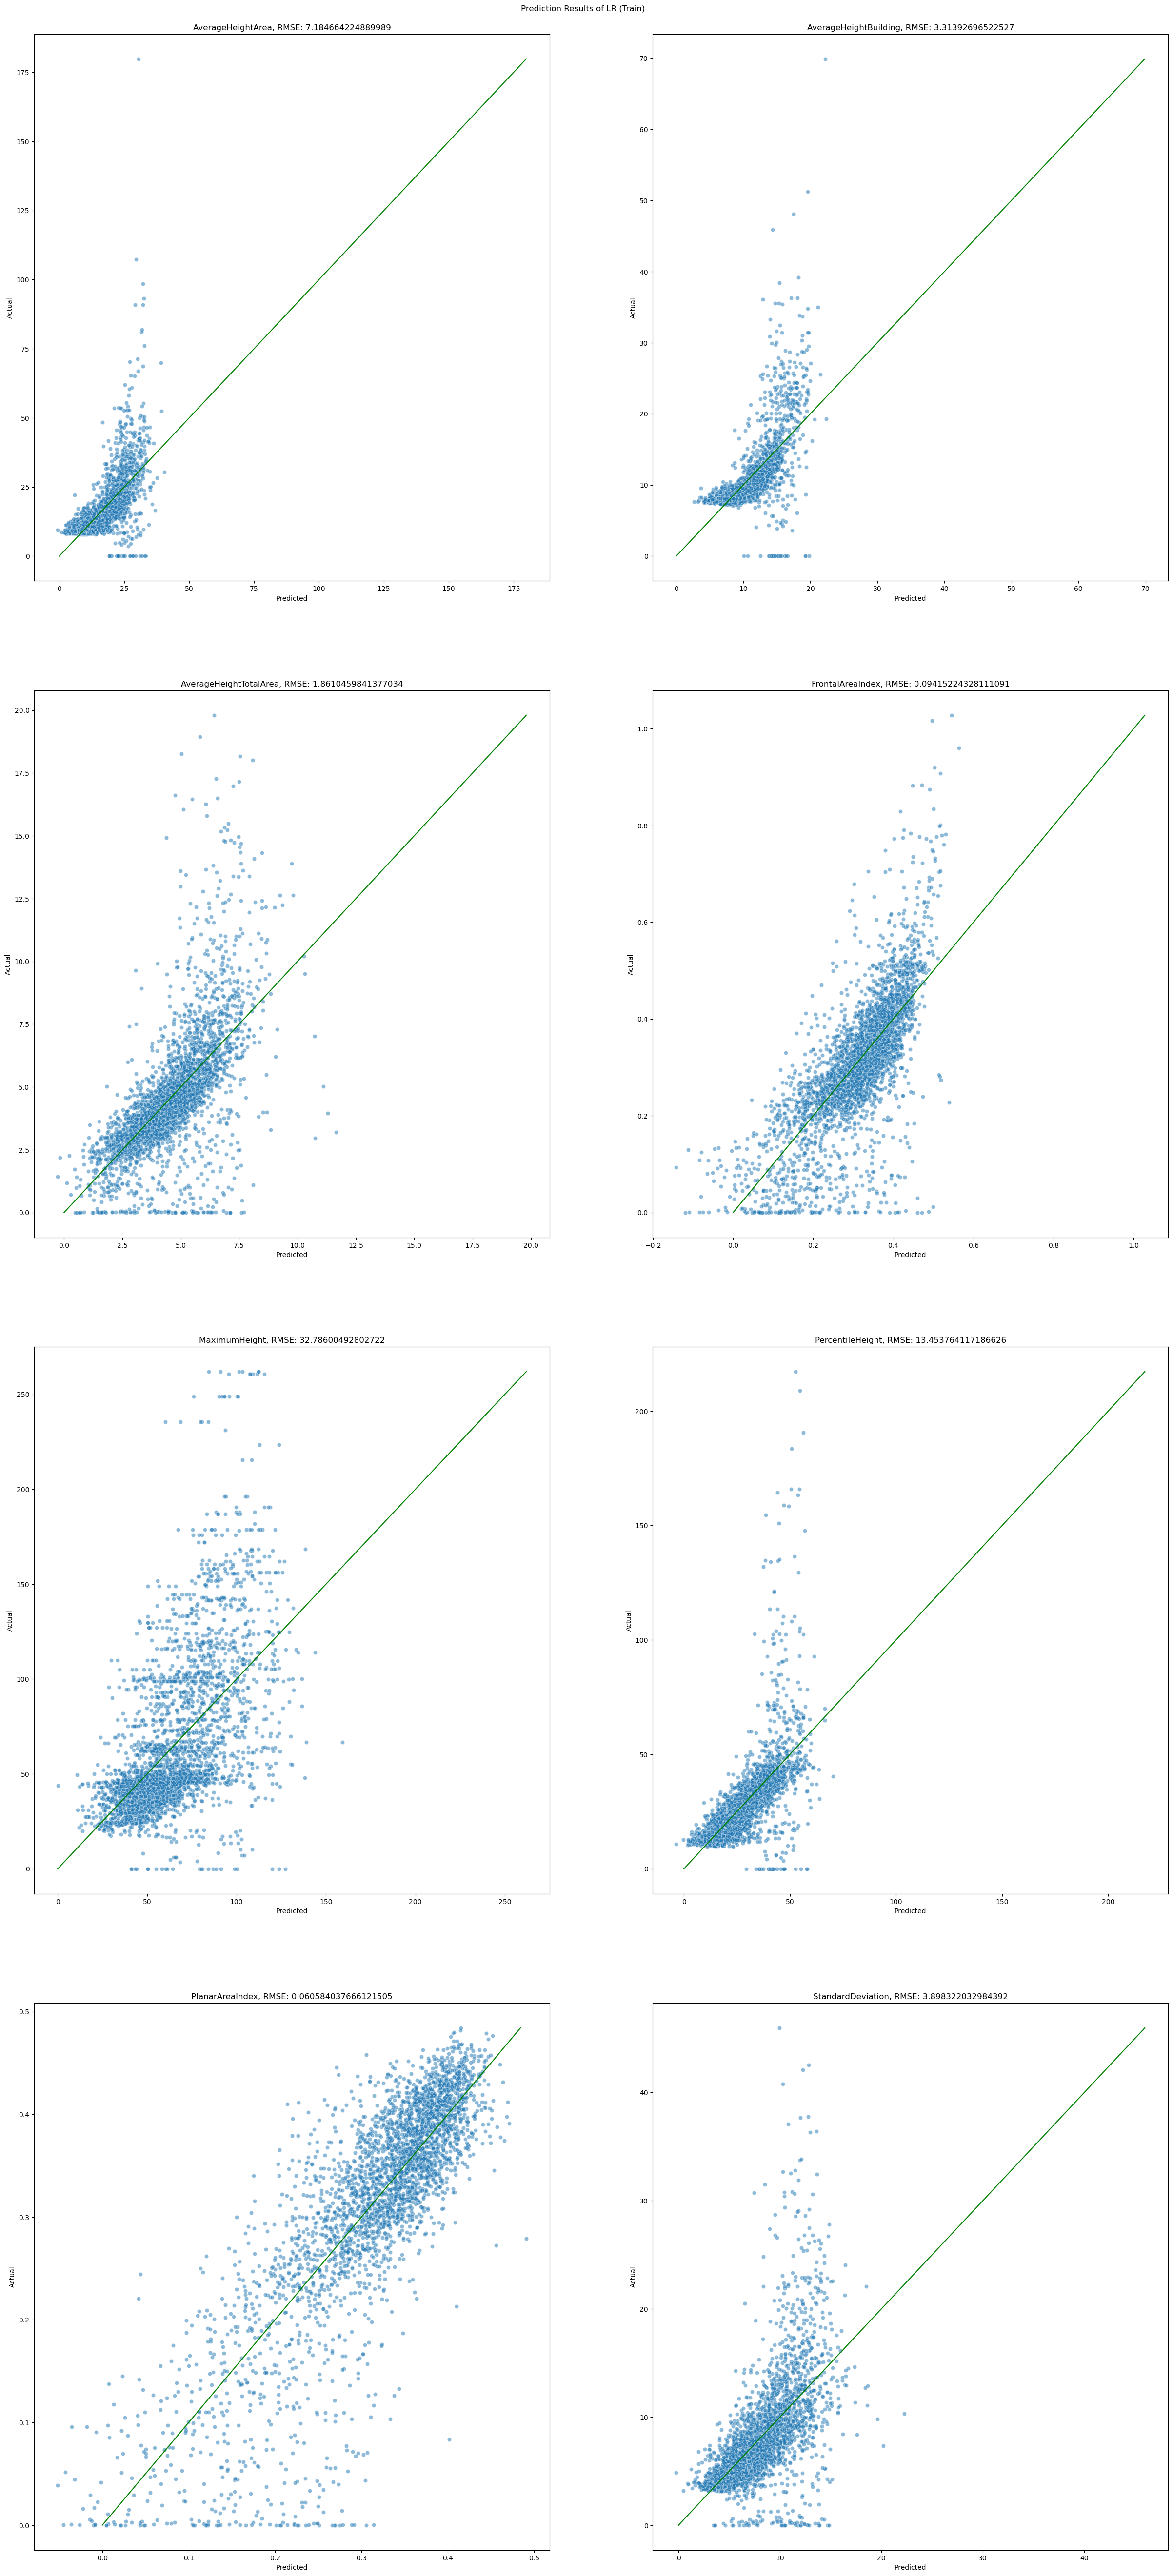

In [26]:
fig, axes = plt.subplots(4, 2, figsize= (30, 60))
fig.suptitle('Prediction Results of LR (Train)')
fig.subplots_adjust(top=0.97)
for ump in range(8):
    # Baseline
    ax = sns.lineplot(x= Y_train[:, ump], y = Y_train[:, ump], ax= axes[ump//2, ump%2], color= "g")

    # LR
    sns.scatterplot(y= Y_train[:, ump], x= regs_mean[ump].predict(x_mean_train), alpha= 0.5, ax= axes[ump//2, ump%2])
    
    # Labels
    ax.set(ylabel= "Actual", xlabel= "Predicted")
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(regs_mean[ump].predict(x_mean_train), Y_train[:, ump]))

    axes[ump//2, ump%2].set_title(f"{UMP[ump]}, RMSE: {rmse}")

### XG Boost

In [50]:
Y_train[:, ump].shape

(0, 8)

In [66]:
import xgboost as xg
from sklearn.metrics import mean_squared_error

xgb_lst = []
for ump in range(8):
    xgb_r = xg.XGBRegressor(n_estimators= 8)
    xgb_r.fit(x_mean_train, Y_train[:, ump])
    xgb_lst.append(xgb_r)


xgb_train_mse = mse_weighted(torch.column_stack([torch.tensor(xgb_lst[ump].predict(x_mean_train)) for ump in range(8)]), torch.tensor(Y_train), UMP_max= dl.train_ds.UMP_max)
xgb_val_mse = mse_weighted(torch.column_stack([torch.tensor(xgb_lst[ump].predict(x_mean_val)) for ump in range(8)]), torch.tensor(Y_val), UMP_max= dl.train_ds.UMP_max)
xgb_train_mse, xgb_val_mse

(tensor(0.0347, grad_fn=<AddBackward0>),
 tensor(0.2024, grad_fn=<AddBackward0>))

In [54]:
xgb_train_mse = mse_weighted(torch.column_stack([torch.tensor(xgb_lst[ump].predict(x_mean_train)) for ump in range(8)]), torch.tensor(Y_train), UMP_max= dl.train_ds.UMP_max)
xgb_val_mse = mse_weighted(torch.column_stack([torch.tensor(xgb_lst[ump].predict(x_mean_val)) for ump in range(8)]), torch.tensor(Y_val), UMP_max= dl.train_ds.UMP_max)
xgb_train_mse, xgb_val_mse

(tensor(0.0347, grad_fn=<AddBackward0>),
 tensor(0.2024, grad_fn=<AddBackward0>))

### New Results

In [ ]:
for ump in range(8):
    print(UMP[ump])
    print(math.sqrt(sklearn.metrics.mean_squared_error(regs_mean[ump].predict(x_mean_train), Y_train[:, ump])), end= " ")
    print(math.sqrt(sklearn.metrics.mean_squared_error(preds[:, ump], Y_train[:, ump])))

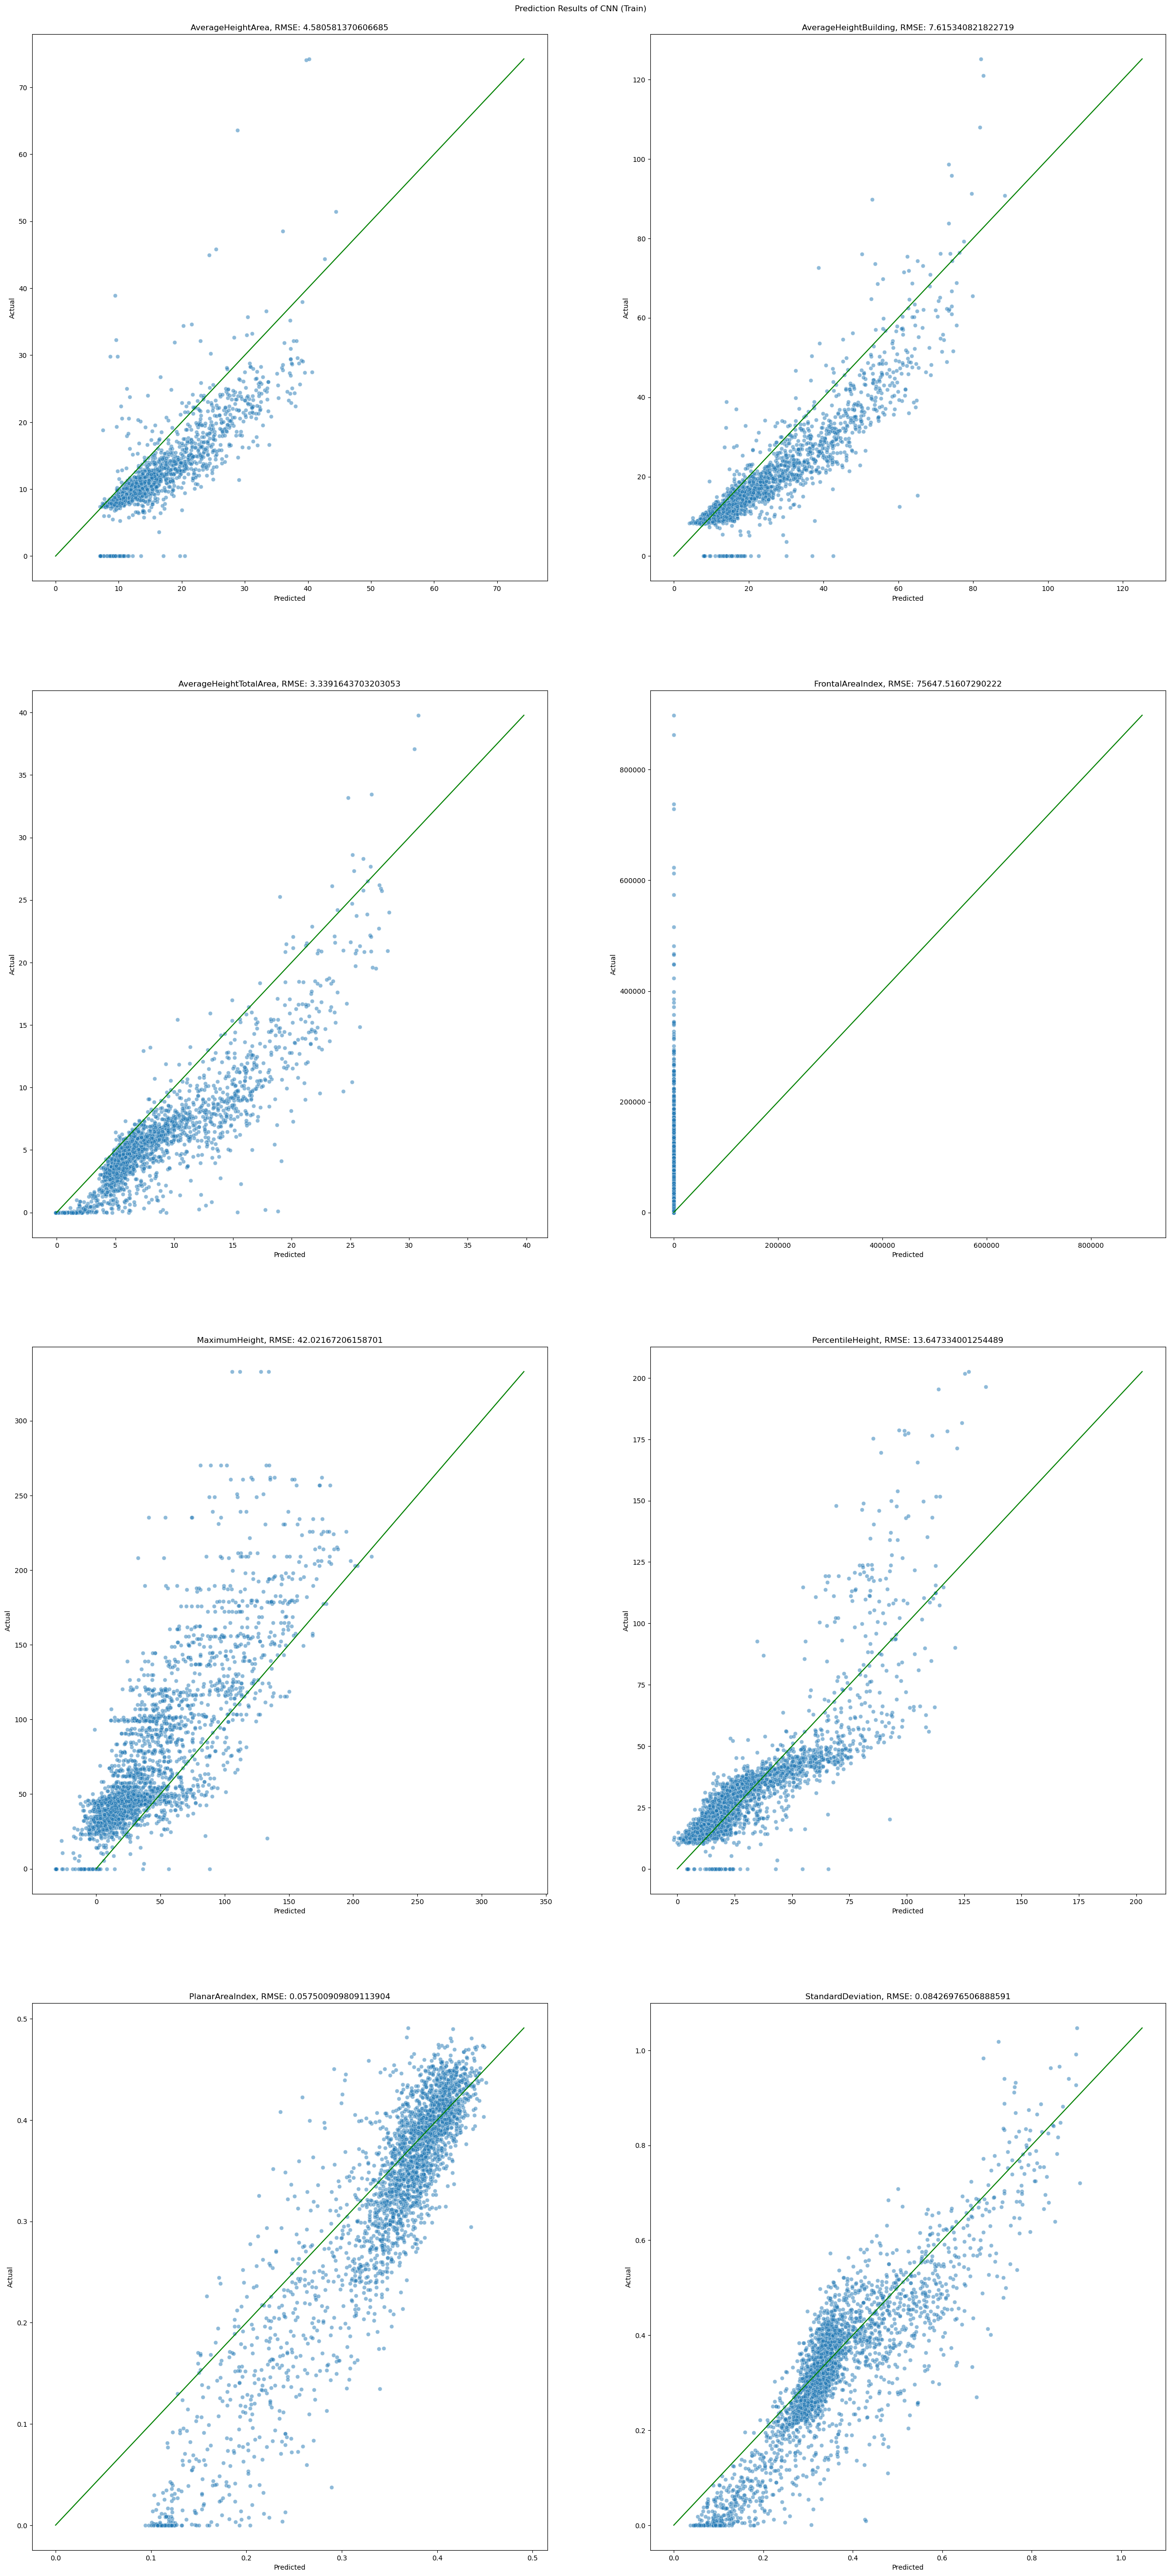

In [24]:
fig, axes = plt.subplots(4, 2, figsize= (30, 60))
fig.suptitle('Prediction Results of CNN (Train)')
fig.subplots_adjust(top=0.97)
for ump in range(8):
    # CNN
    sns.scatterplot(x= preds[:, ump], y= Y_train[:, ump], alpha= 0.5, ax= axes[ump//2, ump%2])
    # Baseline
    ax = sns.lineplot(x= Y_train[:, ump], y = Y_train[:, ump], ax= axes[ump//2, ump%2], color= "g")
    
    # Labels
    ax.set(ylabel= "Actual", xlabel= "Predicted")
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(preds[:, ump], Y_train[:, ump]))

    axes[ump//2, ump%2].set_title(f"{UMP[ump]}, RMSE: {rmse}")

In [26]:
# mse_weighted(preds, Y_train, UMP_max= dl.train_ds.UMP_max)
mse_weighted(preds, Y_train, UMP_max= old_ds_UMP_max)

TensorBase(0.6145, grad_fn=<AliasBackward0>)

In [31]:
mse_weighted(preds, Y_train, UMP_max= dl.train_ds.UMP_max)
# mse_weighted(preds, Y_train, UMP_max= old_ds_UMP_max)

TensorBase(0.2075, grad_fn=<AliasBackward0>)

Train Loss   Val Loss
0     0.873098   0.152584
1     0.631761   0.117446
2     0.502681   0.194960
3     0.386874   0.437756
4     0.287610   0.103369
5     0.252008  13.671713
6     0.215031   1.022033
7     0.170166   0.297430
8     0.166886   0.370096
9     0.157394   0.834968
10    0.129610   0.254452
11    0.137518   0.490832
12    0.117832   0.702859
13    0.119344   0.363180
14    0.120150   0.832943
15    0.104181   1.755985
16    0.093834   1.795122
17    0.094153   1.573235
18    0.094632   1.630912
19    0.091847   1.702414
20    0.088992   1.316128
21    0.087060   1.775453
22    0.074526   1.776354
23    0.079156   1.263237
24    0.069006   1.383188
25    0.073981   1.321005
26    0.068106   1.229257
27    0.070959   1.005693
28    0.071179   1.060825
29    0.064214   0.948830

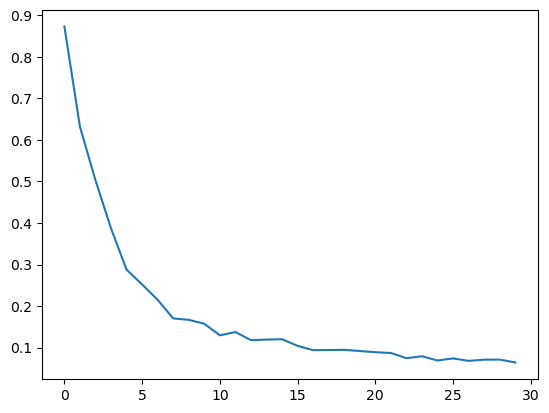

In [20]:
# Plot loss
with open(f"trained_models/model_records_v5_oldds_ump_cut_12ch_8_30.pkl", "rb") as f:
    records = pickle.load(f)
sns.lineplot(x= range(len(records)), y= np.array(records)[:, 0])
# sns.lineplot(x= range(len(records)), y= np.array(records)[:, 1])
pd.DataFrame({"Train Loss": np.array(records)[:, 0], "Val Loss": np.array(records)[:, 1]})

### Old Results

In [23]:
UMP_OLD = ['height_avg_bld', 'height_avg_area', 'height_avg_total', 'height_std',
       'height_max', 'height_percentile', 'planar_index', 'frontal_index']

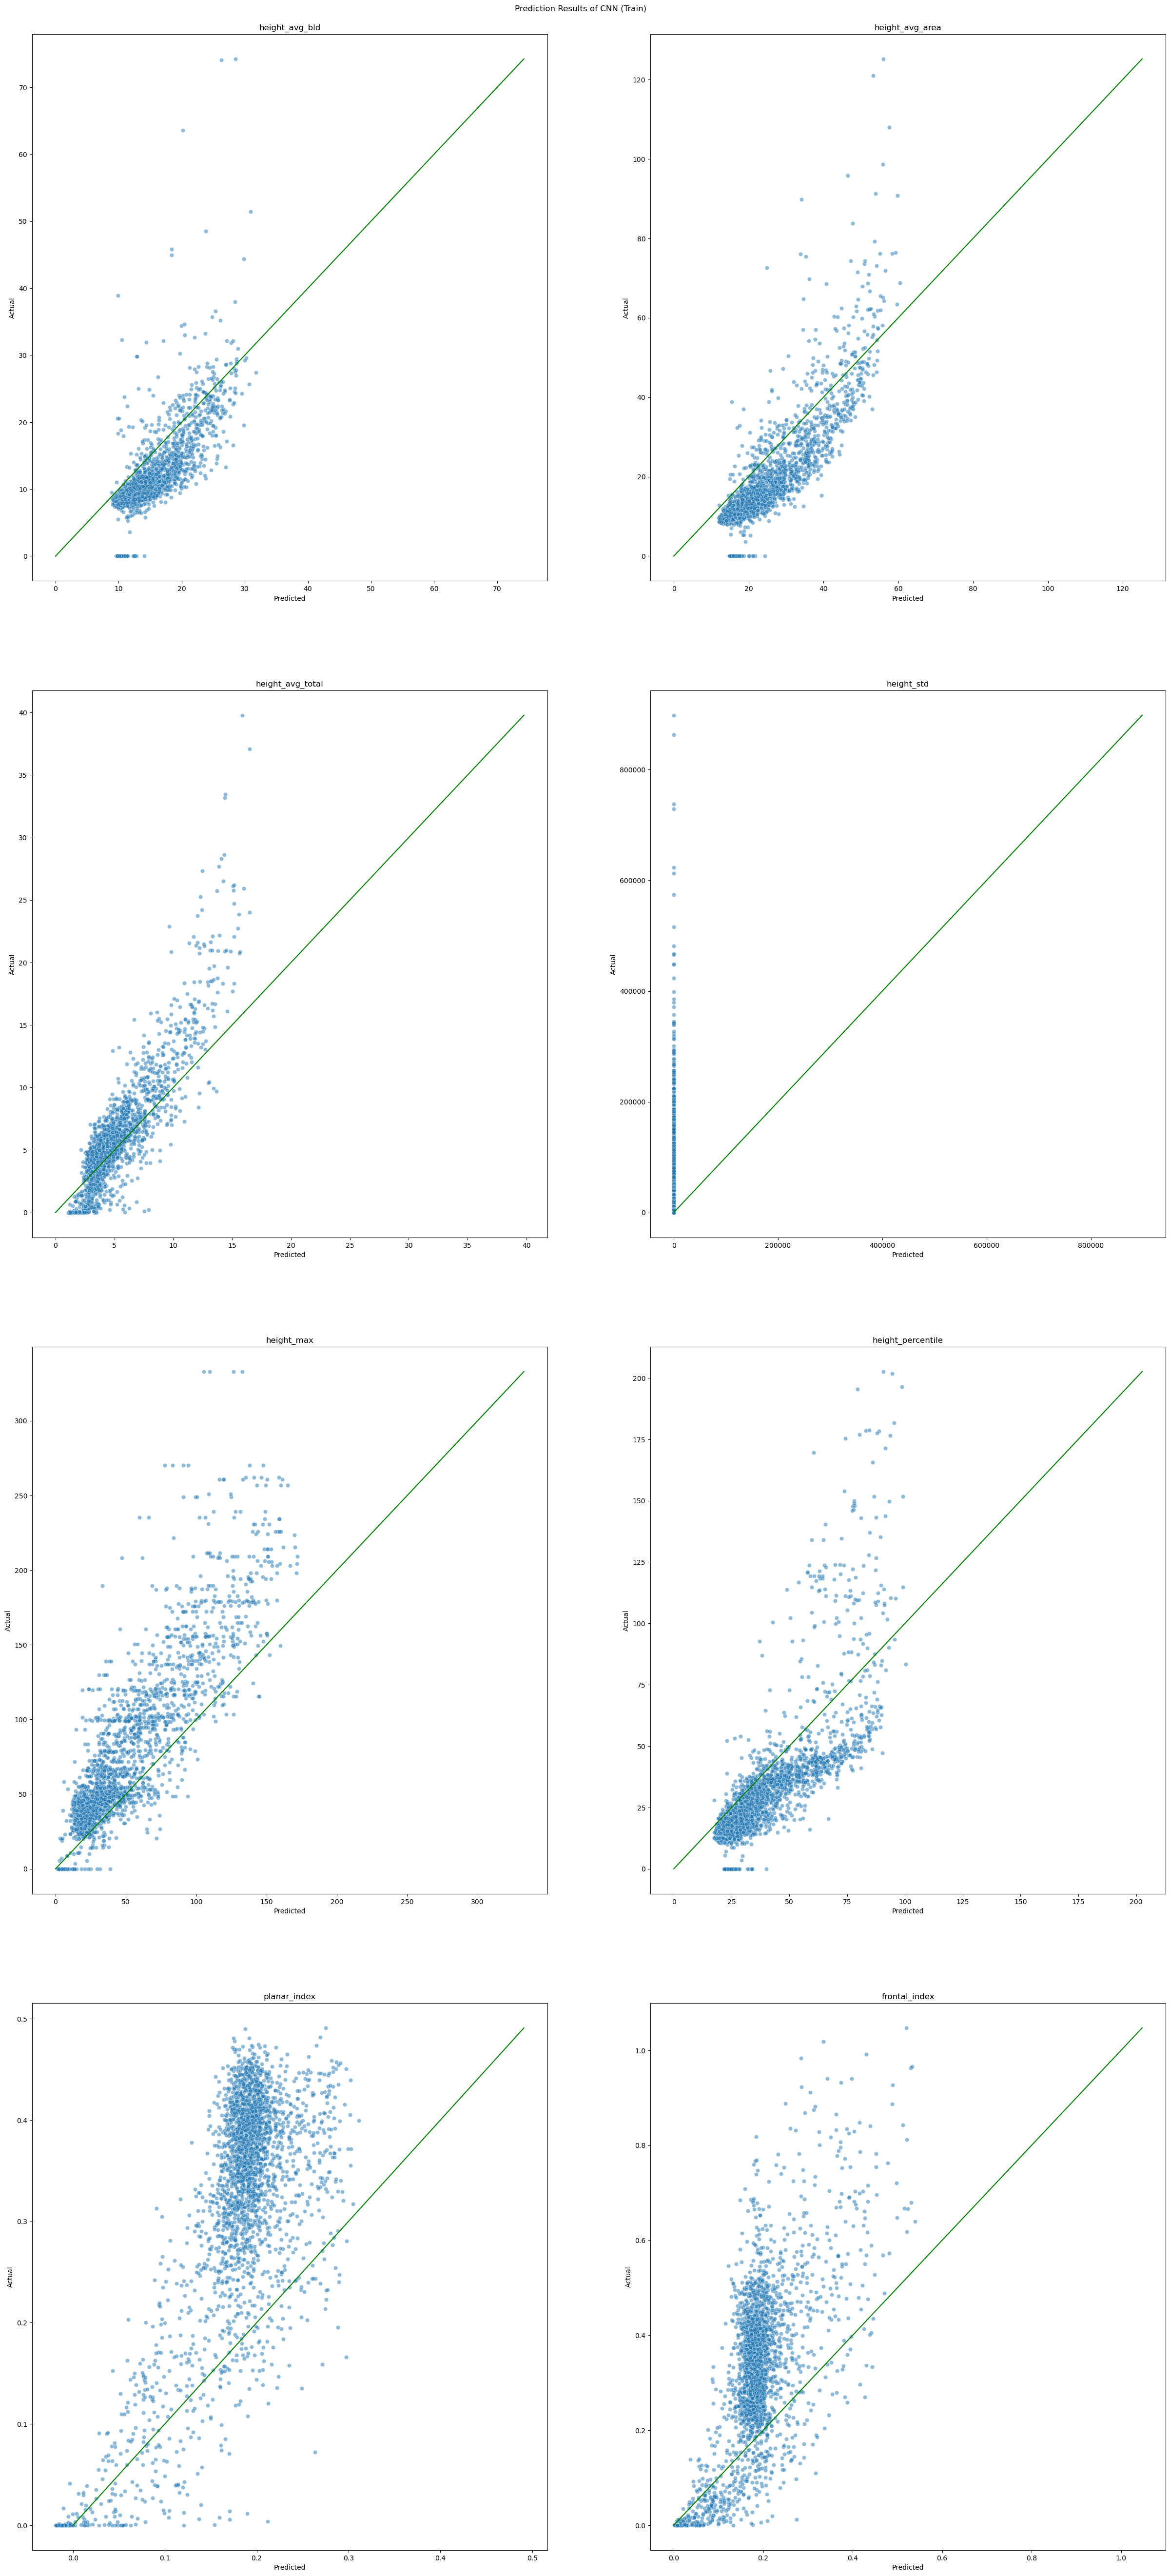

In [25]:
fig, axes = plt.subplots(4, 2, figsize= (30, 60))
fig.suptitle('Prediction Results of CNN (Train)')
fig.subplots_adjust(top=0.97)
for ump in range(8):
    # CNN
    sns.scatterplot(x= preds[:, ump].cpu(), y= Y_train[:, ump], alpha= 0.5, ax= axes[ump//2, ump%2])
    # Baseline
    ax = sns.lineplot(x= Y_train[:, ump], y = Y_train[:, ump], ax= axes[ump//2, ump%2], color= "g")

    # Labels
    ax.set(ylabel= "Actual", xlabel= "Predicted")

    axes[ump//2, ump%2].set_title(f"{UMP_OLD[ump]}")